In [1]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least) #
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal as sg
from datetime import datetime as dt
import xarray as xr

In [2]:
def prcrng(x):
    return (np.nanpercentile(x,84) - np.nanpercentile(x,16))/2.

In [3]:
dir_acs = "/users/rsg/spa/spapapers/Pardo_Globlal_Chla/insitu/reprocessing/netCDF/Graban2020/"
fn_acs = "NAAMES3.nc"

In [4]:
# read ACS (and HPLC) data in xr format
acs = xr.open_dataset(dir_acs + fn_acs)

# check keys
print(acs.keys())

#check attributes
acs['acs_chl'].attrs

# no of samples
print('No. of HPLC samples= ' + str(len(acs.hplc_time)))
print('No of ACS samples= ' + str(len(acs.time)))

KeysView(<xarray.Dataset>
Dimensions:         (time: 18435, hplc_time: 48, acs_wv: 176)
Coordinates:
  * time            (time) datetime64[ns] 2017-08-30T19:11:00 ... 2017-09-22T...
  * hplc_time       (hplc_time) datetime64[ns] 2017-08-30T22:32:00 ... 2017-0...
  * acs_wv          (acs_wv) float64 400.0 402.0 404.0 ... 746.0 748.0 750.0
Data variables:
    hplc_lat        (hplc_time) float64 ...
    hplc_lon        (hplc_time) float64 ...
    hplc_Tot_Chl_a  (hplc_time) float64 ...
    uway_lat        (time) float64 ...
    uway_lon        (time) float64 ...
    acs_chl         (time) float64 ...
    acs_ap          (time, acs_wv) float64 ...)
No. of HPLC samples= 48
No of ACS samples= 18435


['2017-08-30T19:11:00.000000000' '2017-08-30T19:12:00.000000000'
 '2017-08-30T19:13:00.000000000' ... '2017-09-22T19:58:00.000000000'
 '2017-09-22T19:59:00.000000000' '2017-09-22T20:00:00.000000000']


Text(0, 0.5, 'lon')

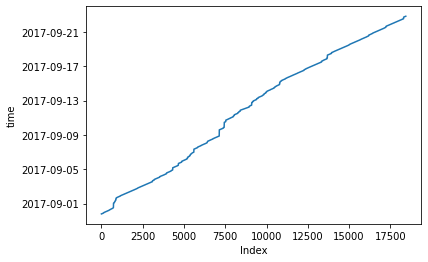

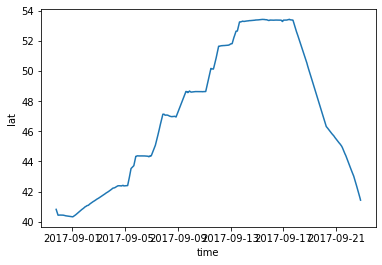

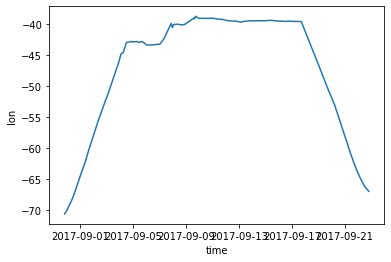

In [5]:
# check time, lat, lon
plt.rcParams.update({'font.size': 9})
    
plt.figure()
plt.plot(acs.time)
plt.xlabel('Index')
plt.ylabel('time')
print(acs.time.values)


plt.figure()
plt.plot(acs.time,acs.uway_lat)
plt.xlabel('time')
plt.ylabel('lat')

plt.figure()
plt.plot(acs.time,acs.uway_lon)
plt.xlabel('time')
plt.ylabel('lon')



In [6]:
# check temporal sample rate
plt.figure()
delta_t = np.median(np.diff(acs.time))
print(delta_t)
print(str(int(delta_t/10**9)) + ' secs')

# == 1 min sample rate for NAAMES1

60000000000 nanoseconds
60 secs


<Figure size 432x288 with 0 Axes>

['hplc_lat', 'hplc_lon', 'hplc_Tot_Chl_a', 'uway_lat', 'uway_lon', 'acs_chl', 'acs_ap']


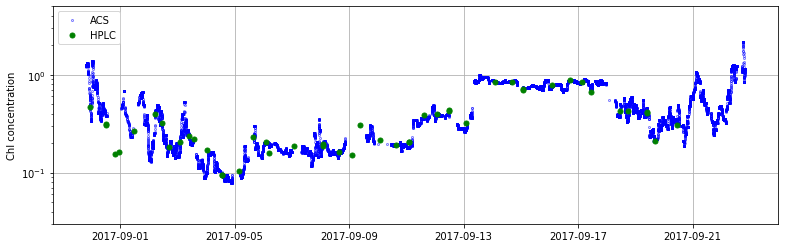

In [7]:
# Test plot of ACS(9) and HPLC Chl prior to match-up
# include emprical adjustment of AC9 chl using AMT
MEDFILT_WIN = 31 # window length of med filter in minutes - note: this assumes data has been binned at 1 minute

#
fig2, ax2 = plt.subplots(1, figsize=(13, 4))
ax2.semilogy(acs.time, sg.medfilt(acs.acs_chl, kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=2, mfc='none', alpha = 0.5, label='ACS')
ax2.grid('on')
plt.legend()
plt.ylim([0.3e-1, 5])
plt.ylabel('Chl concentration')

#
print(list(acs.keys()))
ax2.semilogy(acs.hplc_time, acs.hplc_Tot_Chl_a, 'go', ms=5, alpha=1, label='HPLC')#, mfc='none')
# a2.semilogy(df_CTD.index, df_CTD.Tot_Chl_a, 'ko', ms=7, alpha=1, mfc='none', zorder=60)
# ax2.scatter(df_CTD.index, df_CTD.Tot_Chl_a, c=df_CTD.Bottle.values, s=30, alpha=1, zorder=60, cmap = plt.get_cmap('inferno'), vmin=2, vmax=24)
# ax2.semilogy(df_UND.index, df_UND.Tot_Chl_a, 'ks', ms=7, alpha=0.85, mfc='c')
plt.legend()
#########


In [8]:
# step x - # median filter
plt.figure()
acs['acs_chl'].values = sg.medfilt(acs.acs_chl, kernel_size = MEDFILT_WIN) # apply med filter to acx chl and acx chl debiasesd 
#plt.plot(acs['acs_chl'].values)

# step y  #filters w.r.t. ap(420) (10th element) being > 0
i2kp = np.where((acs.acs_ap[:,10] > 0)) [0]
iy = xr.DataArray(acs.time[i2kp], dims=['time']) 
acs_y = acs.sel(time = iy)
print(len(acs_y['acs_chl'].values))


#step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs_y.acs_chl[:] > 0)) [0]
iz = xr.DataArray(acs_y.time[i2kp], dims=['time']) 
acs_z = acs_y.sel(time = iz)
print(len(acs_z['acs_chl'].values))

# for NAAMES 3 - data looks to have already had effective QC


18435
18435


<Figure size 432x288 with 0 Axes>

In [9]:
acs = []
acs = acs_z # redefine as filtered data structure

In [13]:
# match-ups #

# create series objects
df_hplc = pd.Series(acs['hplc_Tot_Chl_a'].values,index = acs.hplc_time)
df_acs = pd.Series(acs['acs_chl'].values, index = acs.time)
print(len(df_hplc))

# filter replicate hplcs
df_hplc = df_hplc.groupby(df_hplc.index).mean().reindex()
print(len(df_hplc))

#
df_hplc_acs = pd.DataFrame({'Tot_Chl_a': df_hplc, 'acs_chl': df_acs},index = df_hplc.index)
df_hplc_acs = df_hplc_acs.interpolate('index').reindex(df_hplc_acs.index, method='nearest',tolerance='30min') # need to relax index limit (maybe patchy data issue?)

# for this cruise, manually clip points outside range consistent with match-up window tolerance 
df_hplc_acs = df_hplc_acs.drop([df_hplc_acs.index[1], df_hplc_acs.index[2], df_hplc_acs.index[3], df_hplc_acs.index[20], df_hplc_acs.index[21]])

48
41


In [11]:
print(df_hplc)
print(df_acs)
# nans in acs_ch are where there are no match-ups

2017-08-30 22:32:00    0.4690
2017-08-31 12:31:00    0.3125
2017-08-31 19:55:00    0.1540
2017-08-31 23:10:00    0.1630
2017-09-01 11:58:00    0.2670
2017-09-02 05:15:00    0.3970
2017-09-02 11:13:00    0.3190
2017-09-02 16:42:00    0.1830
2017-09-03 02:24:00    0.2040
2017-09-03 09:51:00    0.2350
2017-09-03 14:15:00    0.2190
2017-09-04 00:34:00    0.1720
2017-09-04 13:49:00    0.0945
2017-09-05 03:53:00    0.1050
2017-09-05 15:44:00    0.2330
2017-09-06 02:04:00    0.2060
2017-09-06 05:08:00    0.1580
2017-09-07 01:52:00    0.1860
2017-09-08 02:08:00    0.1920
2017-09-08 15:10:00    0.1620
2017-09-09 02:08:00    0.1530
2017-09-09 09:04:00    0.3100
2017-09-10 02:02:00    0.2180
2017-09-10 15:44:00    0.1910
2017-09-11 02:07:00    0.2070
2017-09-11 14:43:00    0.3920
2017-09-12 02:05:00    0.3970
2017-09-12 11:57:00    0.4335
2017-09-13 02:12:00    0.3240
2017-09-14 02:00:00    0.8530
2017-09-14 16:27:00    0.8480
2017-09-15 02:04:00    0.7110
2017-09-16 02:04:00    0.7770
2017-09-16

In [20]:
# compute residuals (lin and log space)
rres = df_hplc_acs.acs_chl.values / df_hplc_acs.Tot_Chl_a.values - 1
rres_log = np.log10(df_hplc_acs.acs_chl.values)/np.log10(df_hplc_acs.Tot_Chl_a.values) - 1

delta = np.nanmedian(rres)
delta_log = np.nanmedian(rres_log)
sigma = prcrng(rres)
sigma_log = prcrng(rres_log)
N = np.sum(~np.isnan(rres))
N_log = np.sum(~np.isnan(rres_log))

print('Linear metrics')
print(delta, sigma, N)

print('Log metrics')
print(delta_log, sigma_log, N)


Linear metrics
-0.03127211338104918 0.2603782460071997 36
Log metrics
0.035328963277117986 0.3156075667563756 36


['hplc_lat', 'hplc_lon', 'hplc_Tot_Chl_a', 'uway_lat', 'uway_lon', 'acs_chl', 'acs_ap']


/tmp/ipykernel_268135/2373091932.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax2.semilogy(df_hplc.index, df_hplc.values, 'go', ms=5, color='green', alpha=1, label='HPLC_all')#, mfc='none')
/tmp/ipykernel_268135/2373091932.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax2.semilogy(df_hplc_acs.index[~np.isnan(rres)==1], df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1], 'go', ms=5, color='red', alpha=1, label='HPLC matches')#, mfc='none')


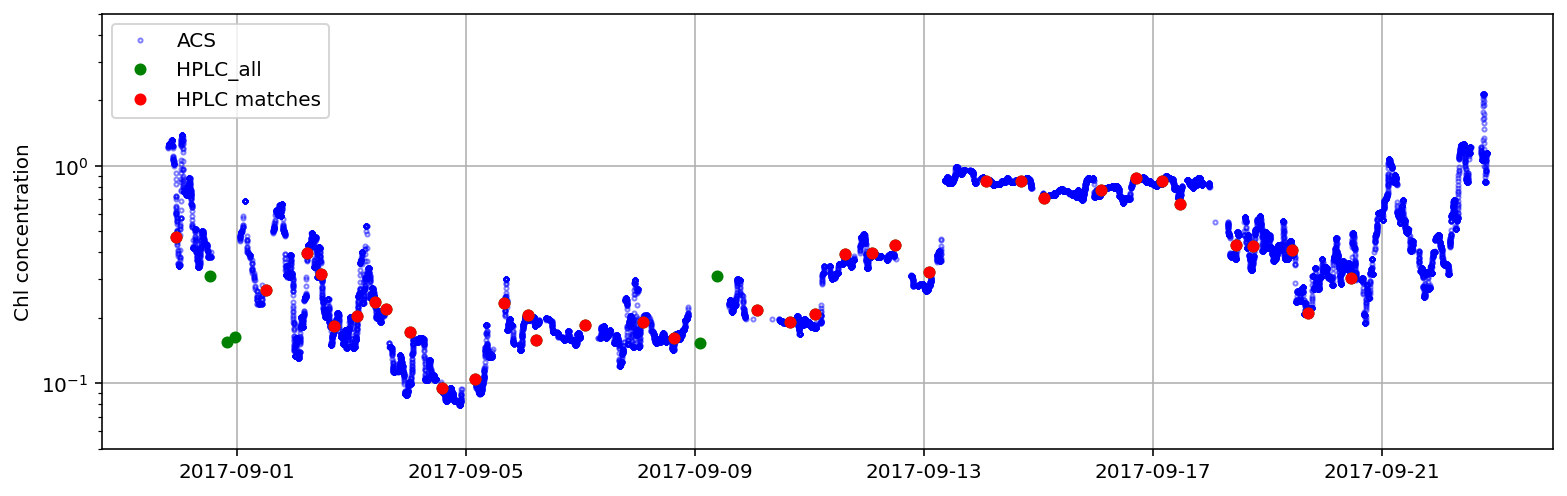

In [21]:
# Test plot of ACS(9) and HPLC Chl post match-up


MEDFILT_WIN = 31 # window length of med filter in minutes - note: this assumes data has been binned at 1 minute. 

#
fig2, ax2 = plt.subplots(1, figsize=(13, 4))
ax2.semilogy(acs.time, sg.medfilt(acs.acs_chl, kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=2, mfc='none', alpha = 0.5, label='ACS')
ax2.grid('on')
plt.legend()
plt.ylim([0.5e-1, 5])
plt.ylabel('Chl concentration')

print(list(acs.keys()))
ax2.semilogy(df_hplc.index, df_hplc.values, 'go', ms=5, color='green', alpha=1, label='HPLC_all')#, mfc='none')
ax2.semilogy(df_hplc_acs.index[~np.isnan(rres)==1], df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1], 'go', ms=5, color='red', alpha=1, label='HPLC matches')#, mfc='none')
plt.legend()
#########




[0.469  0.267  0.397  0.319  0.183  0.204  0.235  0.219  0.172  0.0945
 0.105  0.233  0.206  0.158  0.186  0.192  0.162  0.218  0.191  0.207
 0.392  0.397  0.4335 0.324  0.853  0.848  0.711  0.777  0.875  0.849
 0.669  0.43   0.429  0.411  0.21   0.304 ]


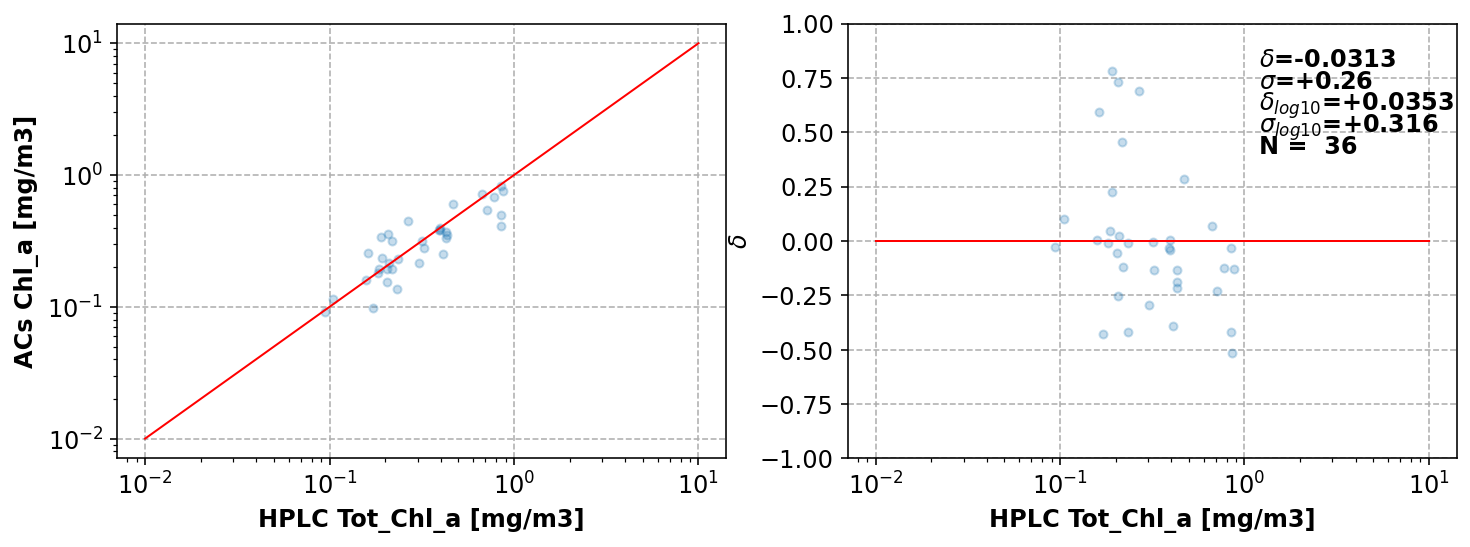

In [22]:
# check time, lat, lon
plt.rcParams.update({'font.size': 12})
    
fig, ax = plt.subplots(1,2, figsize=(12, 4))

ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl.values, 'o', ms=4, alpha=0.25)
x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACs Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('$\delta$', fontweight='bold')
ax[1].set_ylim([-1, 1])
ax[1].text(1.2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.7, r'$\sigma$='+f'{sigma:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.6, r'$\delta_{log10}$='+f'{delta_log:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.5, r'$\sigma_{log10}$='+f'{sigma_log:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.4, f'N = {N: 0}', fontweight='bold')




print(df_hplc_acs.Tot_Chl_a.values)



(-1.0, 1.0)

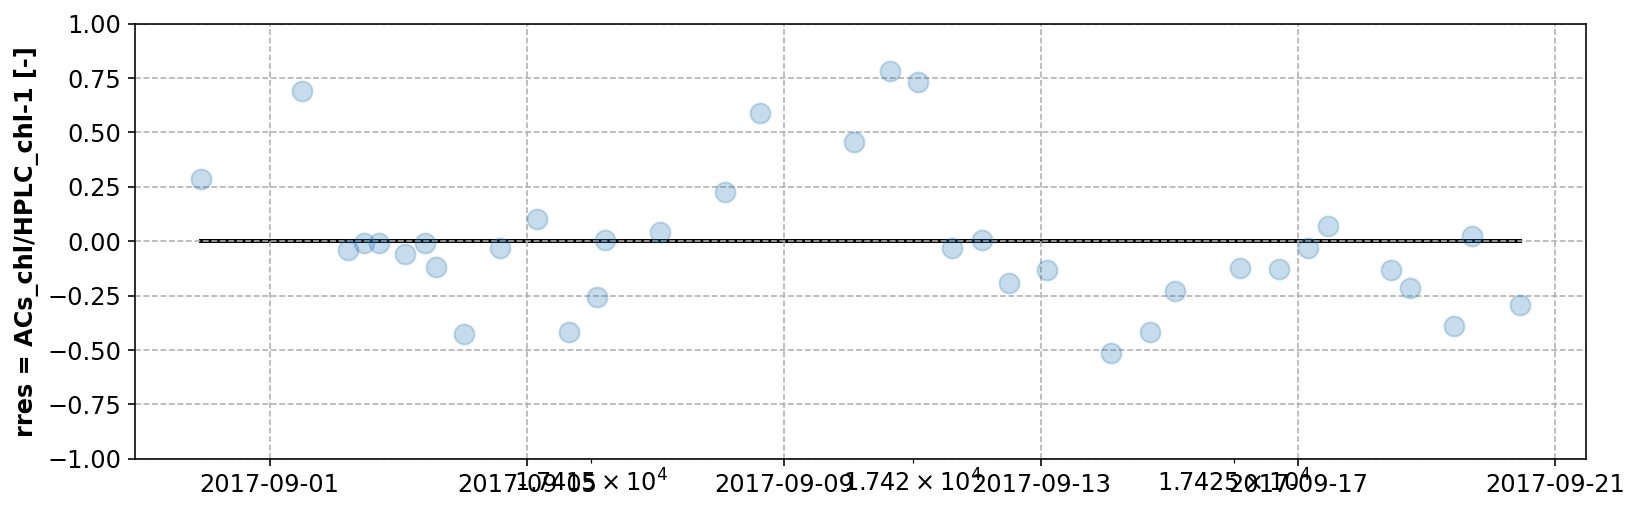

In [23]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.semilogx(df_hplc_acs.index.values, rres, 'o', ms=10, alpha=0.25, zorder=60)
ax.plot(df_hplc_acs.index.values, rres*0, 'k-', lw=2, zorder=1)
ax.set_ylabel('rres = ACs_chl/HPLC_chl-1 [-]', fontweight='bold')
ax.grid('on', ls='--')
ax.set_ylim([-1, 1])

In [24]:
# Apply log transform prior to fitting power-law. Notation follows Brewin 2016. 
import scipy

linear_mod = scipy.stats.linregress(np.log10(0.014*df_hplc_acs.acs_chl.values[~np.isnan(rres)==1]), np.log10(df_hplc_acs.Tot_Chl_a.values[~np.isnan(rres)==1]))

A = np.round(100*linear_mod.intercept)/100
B = np.round(1000*linear_mod.slope)/1000
r_sq = np.round(1000*linear_mod.rvalue**2)/100

r_sq = np.round(1000*linear_mod.rvalue**2)/1000
stderr = np.round(1000*linear_mod.stderr)/1000
interr = np.round(1000*linear_mod.intercept_stderr)/1000

print('A = ' + str(10**A) + ' +/- ' + str(2*10**interr))
print('B = ' + str(B) + ' +/- ' + str(2*stderr))
print('r_sq = ' + str(r_sq))

A = 48.97788193684461 +/- 3.3576080362451206
B = 0.92 +/- 0.188
r_sq = 0.739


In [25]:
# de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
# acs_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan],
#                              'lon [degE]': acs.uway_lon[i2f][innan],
#                             'acs_chl_debiased [mg_m3]': acs.acs_chl_debiased[i2f][innan]
#                           }  ,
# index = acs.time.values[i2f][innan])

In [26]:
# add attributes to acs_chl_debiased #
acs.acs_chl_debiased.attrs["debiasing_equation"] = "acs.acs_chl_debiased = acs.acs_chl*(1-delta)"
acs.acs_chl_debiased.attrs["delta"] = delta
acs.acs_chl_debiased.attrs["sigma"] = sigma
acs.acs_chl_debiased.attrs["units"] = "mg/m3"
acs.acs_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
acs.acs_chl_debiased.attrs["HPLC_Tot_chla"] = df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1].values  # filter nans
acs.acs_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["acs_chl"] = df_hplc_acs[~np.isnan(rres)==1].acs_chl.values # filter nans
acs.acs_chl_debiased.attrs["acs_chl_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
acs.acs_chl_debiased.attrs["match_up_dates"] = df_hplc_acs[~np.isnan(rres)==1].index.format()

In [27]:

print(acs.acs_chl_debiased)
len(acs.acs_chl_debiased.attrs["match_up_dates"])
len(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"])


print(np.min(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"]))
print(np.max(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"])) # quote min max of match-ups for conc-range

<xarray.DataArray 'acs_chl_debiased' (time: 18435)>
array([1.24998307, 1.25359231, 1.25762902, ..., 1.18530983, 1.18530983,
       1.16929448])
Coordinates:
  * time     (time) datetime64[ns] 2017-08-30T19:11:00 ... 2017-09-22T20:00:00
Attributes:
    debiasing_equation:   acs.acs_chl_debiased = acs.acs_chl*(1-delta)
    delta:                -0.03127211338104918
    sigma:                0.2603782460071997
    units:                mg/m3
    comments:             delta=np.nanmedian(rres), sigma=prcrng(rres), rres=...
    HPLC_Tot_chla:        [0.469  0.267  0.397  0.319  0.183  0.204  0.235  0...
    HPLC_Tot_chla_units:  mg/m3
    acs_chl:              [0.60369015 0.45123118 0.3808394  0.31703264 0.1815...
    acs_chl_units:        mg/m3
    processed_on:         2023-11-29 14:05:26.444629
    match_up_dates:       ['2017-08-30 22:32:00', '2017-09-01 11:58:00', '201...
0.0945
0.875


In [28]:

# save updated NetCDF file
dir_acs_out = '/data/datasets/cruise_data/active/ACS_Chl/Glob_OC_matchups/Debiased_nc/'
acs.to_netcdf(dir_acs_out + fn_acs[:-3] + '_with_debiased_chl.nc')
acs.close()
